In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap

from Preprocessing import *
from ExtractGenre import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cleaning data

Apply the functions in Preprocessing.py to clean the midi dataset. There are multiple files that are currupted. 
For this analysis we are also going to use only Midi file with a timestamp of 4/4, like in the reference paper. This filtering is done in CleaningData()

In [12]:
CleaningData()

Cleaning Data : 100%|██████████| 2200/2200 [10:32<00:00,  3.48it/s]


# Preprocessing data:

Firstly we reconstruct the database, transforming all the polyphonic audios into monophonic, keeping the information about the tracks in the midi file. It is done by keeping only the highest pitch from each polyphonic note.

In [13]:
RecreateDatabase()

Recreating Database : 100%|██████████| 2079/2079 [14:22<00:00,  2.41it/s] 


The input of the model has to be a 128x16 matrix as in the paper. The following function clasify the midi tracks into 7 instrumental classes:
- String
- Keyboard
- Aereophone
- Percussion
- Voice
- Synth
- Others

In [19]:
Dataset = PreProcessing()

Preprocessing : 100%|██████████| 2077/2077 [03:46<00:00,  9.17it/s]


In [3]:
# with open('Dataset.pkl', 'wb') as f:
#    pickle.dump(Dataset, f)

with open('Dataset.pkl', 'rb') as f:
   Dataset = pickle.load(f)

for key, value in Dataset.items():
   print(key, '', len(value['Tempo']))

Others  17382
Keyboard  6085
String  14346
Aerophone  4810
Percussion  7348
Voice  4412
Sync  1277


# Model and Architecture

# Genre Detection

Music genre classification generally relies on supervised learning approaches with labeled datasets and it is usually a very difficult taks. Even wors, MIDI dataset does not holds the information about genre, transforming this into an **unsupervised learning** task where we must discover hidden patterns and group similar musical pieces without prior knowledge of their categories.

We employ a feature-based clustering methodology to identify distinct musical genres within our dataset. The core strategy involves extracting meaningful musical characteristics from MIDI files and applying clustering algorithms to reveal natural groupings that correspond to different musical styles.

**Whole-song analysis**: We compute global features that capture the overall characteristics of each piece, including tempo, rhythmic patterns, melodic range, and dynamic properties. These features represent what a listener perceives when hearing the complete musical work.

**Track-level aggregation**: Since MIDI files contain multiple instrumental tracks, we extract features from individual tracks and then aggregate them using statistical measures (mean, maximum, standard deviation). This approach provides insights into instrumental diversity, arrangement complexity, and the interaction between different musical parts while maintaining a consistent feature vector size across songs with varying numbers of tracks.

Our feature set comprises **22 carefully selected attributes** spanning multiple musical dimensions:

- **Rhythmic features**: Tempo, rhythmic regularity, syncopation level, and note density
- **Melodic features**: Pitch range, average pitch, melodic direction changes, and interval patterns  
- **Dynamic features**: Velocity characteristics and dynamic contrast
- **Structural features**: Song length and melodic complexity measures
- **Instrumentation features**: Instrument family ratios and ensemble diversity metrics

This comprehensive feature representation captures the essential characteristics that distinguish different musical genres, from the rhythmic complexity of jazz to the harmonic richness of classical music, enabling unsupervised algorithms to identify meaningful musical categories within our dataset.

The identification of the genre of the song helps us to train specific model that can generate songs with specific characteristics

In [5]:
DatasetFeatures = Clustering()

100%|██████████| 2050/2050 [04:05<00:00,  8.34it/s]

Number of Excluded songs: 7


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


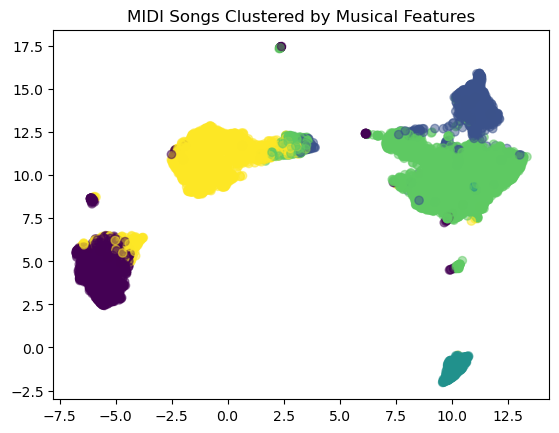

In [15]:
Scaler = StandardScaler()
NormFeatures = Scaler.fit_transform(list(DatasetFeatures.values()))

Kmeans = KMeans(n_clusters = 5, random_state=12)
cluster = Kmeans.fit_predict(NormFeatures)

reducer = umap.UMAP(n_components=2)
features_2d = reducer.fit_transform(NormFeatures)


plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha = 0.5, c=cluster, cmap='viridis')
plt.title('MIDI Songs Clustered by Musical Features')
plt.show()

In [17]:
ClusteringDataframe = pd.DataFrame([{'Song name': k, 'Features': v} for k, v in DatasetFeatures.items()])
ClusteringDataframe['Cluster'] = cluster
ClusteringDataframe

,Song name,Features,Cluster
0,The Smashing Pumpkins/Thirty-Three.1.mid,"[126, 0.001441043428923195, 0.6835375599360682...",4
1,"The Smashing Pumpkins/Tonight, Tonight.mid","[142, 0.0007193061988471649, 0.676491994177583...",4
2,"The Smashing Pumpkins/Tonight, Tonight.1.mid","[142, 0.008674070354537475, 0.5568475452196382...",0
3,"The Smashing Pumpkins/Tonight, Tonight.2.mid","[142, 0.002871029347767895, 0.6764919941775837...",3
4,The Smashing Pumpkins/Disarm.1.mid,"[130, 0.005310146705468056, 0.5031055900621118...",3
...,...,...,...
11633,Tool/Sober.mid,"[156, 0.0011833146562528088, 0.382543103448275...",4
11634,Tool/Intolerance.mid,"[194, 0.0006441368879858763, 0.658475894245723...",4
11635,Randy Crawford/Diamante.mid,"[120, 0.005642584228633196, 0.5714285714285714...",0
11636,Randy Crawford/One Day I'll Fly Away.1.mid,"[79, 0.006562922594618446, 0.6823529411764706,...",0
